### import libraries

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import os

from PIL import Image
from torchvision import transforms

from torchsummary import summary as summary_
from models.unet import Unet
from tqdm import tqdm, tqdm_notebook

from dataloaders.TGSSaltDataloader import *

import cv2
from visualization import *

c:\Users\Interaction Lab\anaconda3\envs\vision\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


### load data

In [2]:
# Converting the image into the desired form
def load_image(img_path, show=False):
    img = cv2.imread(img_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (128,128))
    img_tensor = np.array(img)                   
    #img_tensor = np.expand_dims(img_tensor, axis=0)         

    return img_tensor

x = []
y = []

def get_image(path):
    data =[]
    for subdir, dirs, files in os.walk(path):
        for f in files:
            path = os.path.join(subdir, f)
            img = load_image(path)     
            img = img/255.0
            data.append(img)
    return data


x = get_image('datasets/TGSSalt/train/images')
y = get_image('datasets/TGSSalt/train/masks')
x_train, y_train = np.asarray(x), np.asarray(y)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

print("shape of x_train : ", x_train.shape)
print("shape of y_train : ", y_train.shape)
print("shape of x_test : ", x_test.shape)
print("shape of y_test : ", y_test.shape)

shape of x_train :  (3400, 128, 128)
shape of y_train :  (3400, 128, 128)
shape of x_test :  (600, 128, 128)
shape of y_test :  (600, 128, 128)


### hyperparameter settings

(제일 중요함)

In [4]:
device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

number_epoch    = 30
size_minibatch  = 32
learning_rate   = 0.05
weight_decay    = 0

x_list = []
y_list = []

### custom data loader for the PyTorch framework

In [5]:
# 내 방식
# 트렌스폼 구현하기
class ToTensor(object):
    def __call__(self, input):

        input = input.transpose((2, 0, 1)).astype(np.float32)
        # label = label.transpose((2, 0, 1)).astype(np.float32)
        
        input = torch.from_numpy(input)

        return input

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, input):

        input = (input - self.mean) / self.std
        
        return input
    
class dataset(Dataset):
    
    def __init__(self, input, label, transform=None):
        
        self.input  = input
        self.label  = label 
        
        self.transform = transform
    
    def __getitem__(self, index):
        
        input   = self.input[index]
        label   = self.label[index]
        
        input   = torch.FloatTensor(input).unsqueeze(dim=0)
        # input   = torch.FloatTensor(input)
        # input   = CenterCrop([96, 96])(input)
        
        label   = torch.FloatTensor(label).unsqueeze(dim=0)
        # label   = CenterCrop([96, 96])(label)
        
        # input = torch.unsqueeze(input, 0)
        # label = torch.unsqueeze(label, 0)
        
        if self.transform:
            input = self.transform(input)

        return input, label
    
    def __len__(self):
        
        return self.input.shape[0]

### construct datasets and dataloaders for training and testing

In [6]:
transformation = transforms.Compose([transforms.ToPILImage(), transforms.Resize((128, 128)), transforms.ToTensor()])

dataset_train           = dataset(x_train, y_train, transform=None)
dataset_test            = dataset(x_test, y_test, transform=None)

dataloader_train            = DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)
dataloader_test             = DataLoader(dataset_test, batch_size=size_minibatch, shuffle=False, drop_last=True)

In [7]:
(image_train, label_train)  = dataset_train[0]
print('*******************************************************************')
print('shape of the image in the training dataset:', image_train.shape)
print('shape of the label in the training dataset:', label_train.shape)

*******************************************************************
shape of the image in the training dataset: torch.Size([1, 128, 128])
shape of the label in the training dataset: torch.Size([1, 128, 128])


### model creation

In [8]:
model       = Unet(input_channel=1, output_channel=1, channel_list=[16, 32, 64, 128, 256]).to(device)
optimizer   = torch.optim.Adam(model.parameters(), lr=learning_rate)

summary_(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             160
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,320
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
         MaxPool2d-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           4,640
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,248
      BatchNorm2d-12           [-1, 32, 64, 64]              64
             ReLU-13           [-1, 32, 64, 64]               0
        MaxPool2d-14           [-1, 32,

### compute loss

In [9]:
def compute_loss(prediction, label):
    # ==================================================
    # fill up the blank
    #
    bce = nn.BCEWithLogitsLoss().to(device)
    
    # prediction = torch.squeeze(prediction, dim=1)
    # label = torch.squeeze(label, dim=1)

    loss = bce(prediction, label)
    
    # 
    # ==================================================
    loss_value  = loss.item()

    return loss, loss_value

### compute accuracy

In [10]:
def compute_accuracy(prediction, label):
    
    prediction  = prediction.squeeze(axis=1)
    label       = label.squeeze(axis=1)

    prediction_binary   = (prediction >= 0.5).cpu().numpy()
    label               = label.bool().cpu().numpy()
    
    region_intersection = prediction_binary & label
    region_union        = prediction_binary | label

    area_intersection   = region_intersection.sum(axis=1).sum(axis=1).astype(float)
    area_union          = region_union.sum(axis=1).sum(axis=1).astype(float)

    eps         = np.finfo(float).eps
    correct     = area_intersection / (area_union + eps)
    accuracy    = correct.mean() * 100.0
    
    return accuracy

### variables for the learning curve

In [11]:
loss_mean_train     = np.zeros(number_epoch)
loss_std_train      = np.zeros(number_epoch)
accuracy_mean_train = np.zeros(number_epoch)
accuracy_std_train  = np.zeros(number_epoch)

loss_mean_test      = np.zeros(number_epoch)
loss_std_test       = np.zeros(number_epoch)
accuracy_mean_test  = np.zeros(number_epoch)
accuracy_std_test   = np.zeros(number_epoch)

### train

In [12]:
def train(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.train()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        image.requires_grad = True
        label.requires_grad = True


        prediction          = model(image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)

### test

In [13]:
def test(model, dataloader):

    loss_epoch      = []
    accuracy_epoch  = []

    model.eval()

    for index_batch, (image, label) in enumerate(dataloader):

        image = image.to(device)
        label = label.to(device)

        prediction          = model(image)
        loss, loss_value    = compute_loss(prediction, label)
        accuracy            = compute_accuracy(prediction, label)
        
      
        loss_epoch.append(loss_value)
        accuracy_epoch.append(accuracy)

    loss_mean_epoch     = np.mean(loss_epoch)
    loss_std_epoch      = np.std(loss_epoch)

    accuracy_mean_epoch = np.mean(accuracy_epoch)
    accuracy_std_epoch  = np.std(accuracy_epoch)

    loss        = {'mean' : loss_mean_epoch, 'std' : loss_std_epoch}
    accuracy    = {'mean' : accuracy_mean_epoch, 'std' : accuracy_std_epoch}

    return (loss, accuracy)  

In [14]:

# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm_notebook(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    (loss_train, accuracy_train) = train(model, dataloader_train)

    loss_mean_train[i]      = loss_train['mean']
    loss_std_train[i]       = loss_train['std']

    accuracy_mean_train[i]  = accuracy_train['mean']
    accuracy_std_train[i]   = accuracy_train['std']

    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    (loss_test, accuracy_test) = test(model, dataloader_test)

    loss_mean_test[i]      = loss_test['mean']
    loss_std_test[i]       = loss_test['std']

    accuracy_mean_test[i]  = accuracy_test['mean']
    accuracy_std_test[i]   = accuracy_test['std']

    print(f"epoch : {i}")
    print(f"\ttrain loss : {loss_train['mean']}, train acc : {accuracy_train['mean']}")
    print(f"\ttest loss  : {loss_test['mean']},  test acc  : {accuracy_test['mean']}")

c:\Users\Interaction Lab\anaconda3\envs\vision\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/30 [00:00<?, ?it/s]

epoch : 0
	train loss : 0.534480759276534, train acc : 2.3803173065446424
	test loss  : 0.7198799682988061,  test acc  : 17.423614975577593
epoch : 1
	train loss : 0.44751868664093736, train acc : 10.1673227881515
	test loss  : 0.4165217942661709,  test acc  : 1.9949713474764923
epoch : 2
	train loss : 0.3747354288989643, train acc : 16.685466728411146
	test loss  : 0.4326106193992827,  test acc  : 22.698886540234977
epoch : 3
	train loss : 0.35649974067818446, train acc : 20.45550307252615
	test loss  : 0.31435610519515145,  test acc  : 23.65268430143109
epoch : 4
	train loss : 0.3291447806470799, train acc : 23.515288077612528
	test loss  : 0.5253171987003751,  test acc  : 5.271072994365934
epoch : 5
	train loss : 0.3173441102482238, train acc : 25.007572804363623
	test loss  : 0.3519979930586285,  test acc  : 18.833150425659863
epoch : 6
	train loss : 0.29782832188988634, train acc : 26.990877446070424
	test loss  : 0.28673118435674244,  test acc  : 30.039557823967087
epoch : 7
	tra

[plot examples of the training images]



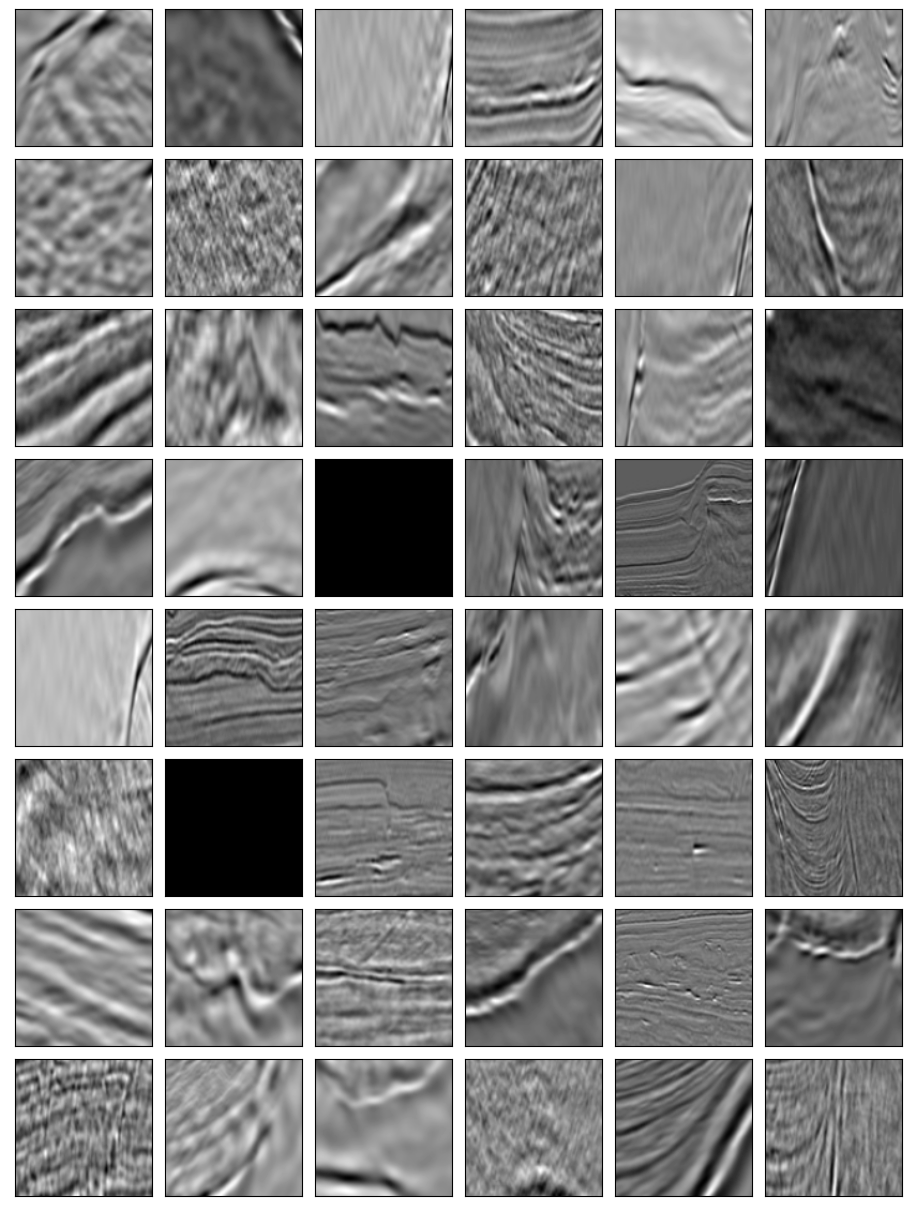

In [15]:
plot_input_images(dataset_train, '[plot examples of the training images]')

[plot examples of the training segmentation labels]



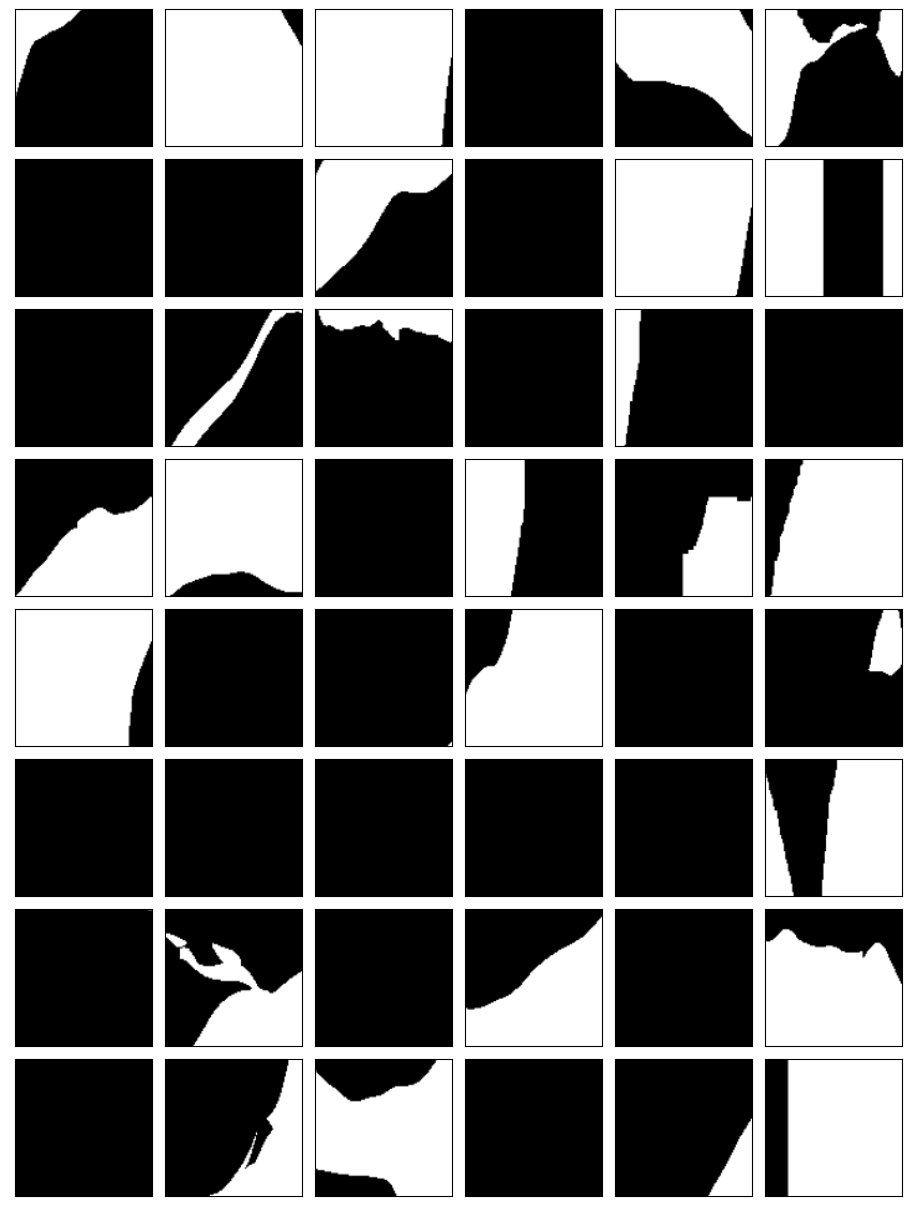

In [18]:
plot_label_images(dataset_train, '[plot examples of the training segmentation labels]')

[plot examples of the training segmentation results]



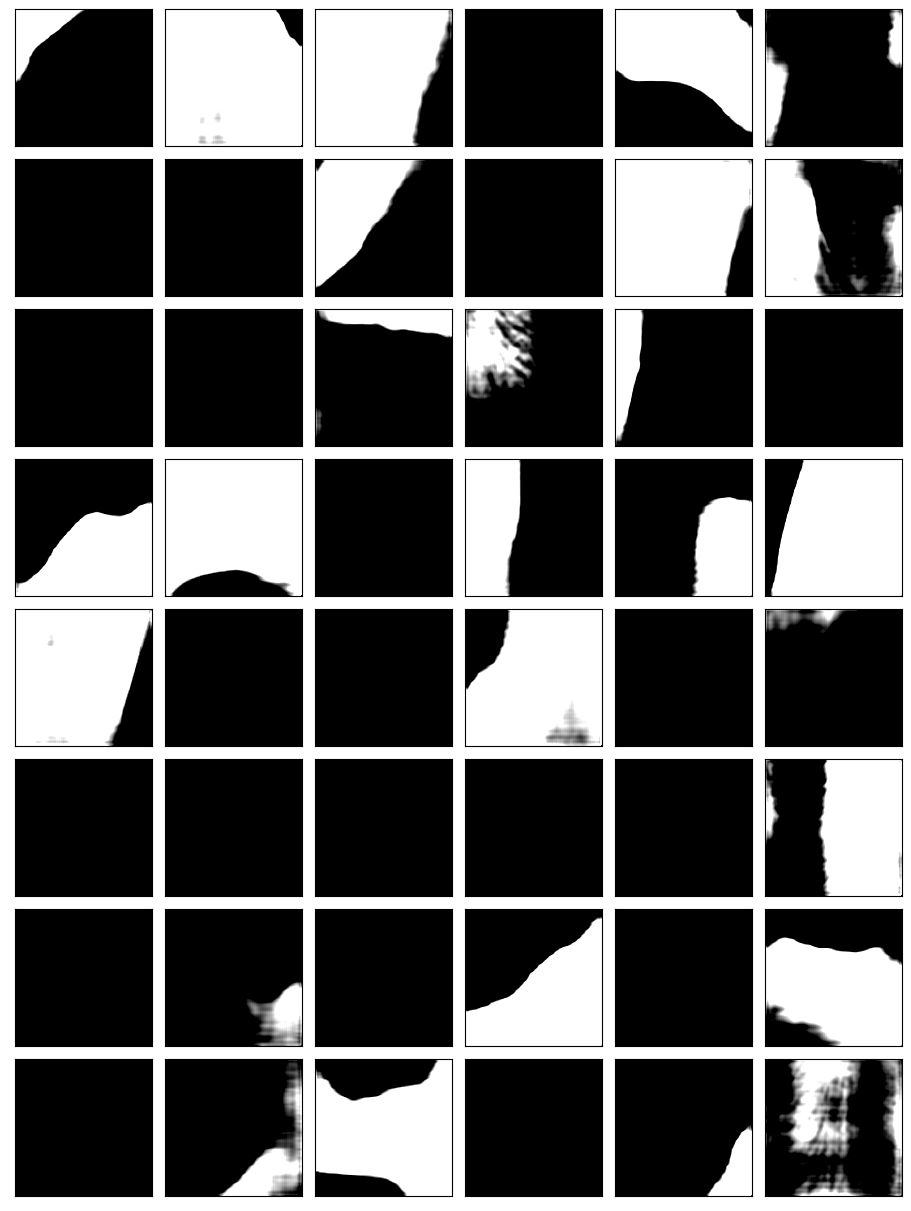

In [19]:
plot_prediction_images(model, dataset_train, '[plot examples of the training segmentation results]')